In [1]:
# Ignore Warnings 
import warnings
warnings.simplefilter(action='ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [2]:
def fix_meta():        # Meta Data Had Some Issue Which Was Later Fixed By The Publisher
    global meta_df
    meta_fix = pd.read_csv("./Data/metadata_cite_day_2_donor_27678.csv", index_col = 'cell_id')
    filter_out = meta_df[(meta_df.day == 2) & (meta_df.donor == 27678)].index
    meta_df.drop(index = filter_out, inplace = True)
    meta_df = pd.concat([meta_df, meta_fix], axis = 0)

In [3]:
meta_df = pd.read_csv("./Data/metadata.csv", index_col = 'cell_id')
fix_meta()
meta_df

,day,donor,cell_type,technology
cell_id,,,,
e0dde41ed6f2,3,27678,MasP,citeseq
25b1de7f18f6,3,27678,MkP,citeseq
59e175749a4c,3,27678,MkP,citeseq
cc43f415f240,3,27678,NeuP,citeseq
cf6cb48a1aca,3,27678,HSC,citeseq
...,...,...,...,...
be92120b3a00,2,27678,HSC,citeseq
396d0c31d41c,2,27678,HSC,citeseq
ef6bf272cdcf,2,27678,EryP,citeseq


Around 2.7 Lakh Observations 

In [4]:
print('-' * 65)
print('Data Types For Columns : \n', meta_df.dtypes)
print('-' * 65)
print('Number Of Duplicated Cells If Any : ', meta_df.index.duplicated().sum())
print('-' * 65)
print('Number Of Null Values : \n', meta_df.isnull().sum())
print('-' * 65)
print('Unique Values : ')
for col in meta_df.columns:
    uniq = meta_df[col].unique()
    print(f'{len(uniq)} {col} : {uniq}')
print('-' * 65)

-----------------------------------------------------------------
Data Types For Columns : 
 day            int64
donor          int64
cell_type     object
technology    object
dtype: object
-----------------------------------------------------------------
Number Of Duplicated Cells If Any :  0
-----------------------------------------------------------------
Number Of Null Values : 
 day           0
donor         0
cell_type     0
technology    0
dtype: int64
-----------------------------------------------------------------
Unique Values : 
5 day : [ 3  4  7  2 10]
4 donor : [27678 32606 13176 31800]
8 cell_type : ['MasP' 'MkP' 'NeuP' 'HSC' 'EryP' 'MoP' 'BP' 'hidden']
2 technology : ['citeseq' 'multiome']
-----------------------------------------------------------------


------------

#### **The Data Is Sampled In Following Manner :**
![](Single-Cell-Analysis/sampling_img.jpg)

In [5]:
meta_cite = meta_df[meta_df.technology == 'citeseq'].drop(columns = 'technology')
meta_multi = meta_df[meta_df.technology == 'multiome'].drop(columns = 'technology')
print("\n", "Samples From CiteSeq Sampling : ", meta_cite.shape, "\n", "Samples From  Multiome Sampling : ", meta_multi.shape)


 Samples From CiteSeq Sampling :  (119191, 3) 
 Samples From  Multiome Sampling :  (152956, 3)


About 1.2 Lakh CiteSeq Samples and About 1.5 Lakh Mutiome Samples

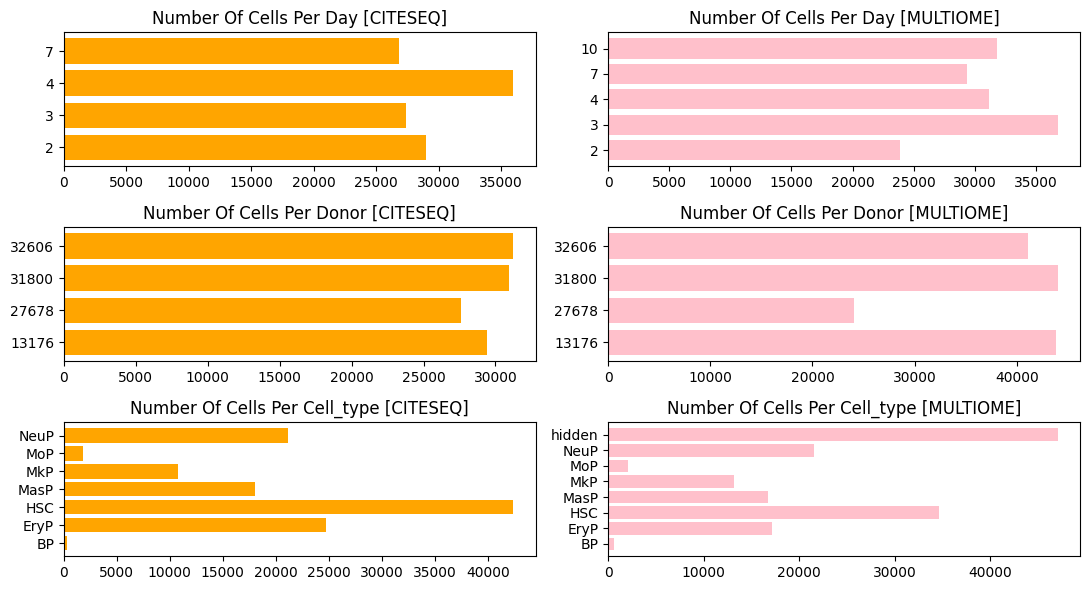

In [6]:
_, axs = plt.subplots(3, 2, figsize=(11, 6))
for col, ax in zip(meta_cite.columns, axs.ravel()[0 : 6 : 2]):
    to_plot = meta_cite[col].value_counts().sort_index()
    ax.barh(to_plot.index.astype('str'),to_plot.values, color = 'orange')
    ax.set_title(f'Number Of Cells Per {col[0].upper() + col[1:]} [CITESEQ]')

for col, ax in zip(meta_multi.columns, axs.ravel()[1 : 6 : 2]):
    to_plot = meta_multi[col].value_counts().sort_index()
    ax.barh(to_plot.index.astype('str'),to_plot.values, color = 'pink')
    ax.set_title(f'Number Of Cells Per {col[0].upper() + col[1:]} [MULTIOME]')
plt.tight_layout()
plt.show()

**OBSERVATIONS**
- No sampling for citeseq for day 10
- Donor 27678 has contributed comparitively less in both the sampling methods, we can use it's data as our test data
- Most of the cells are hidden in Multiome, which makes sense, as cell types are determined by looking at RNA in a cell, which is to be predicted by us
- Hematopoietic stem cells (HSCs) are multipotent primitive cells that can develop into all types of blood cells, that is why they are highest in number as they are the ones to convert into other cells
- BP is least produced cell type

In [7]:
def stacked_plot(data, a, b, plot = None, ax = None):
    to_plot = data.copy()
    crstb = pd.crosstab(index = to_plot[a], columns = to_plot[b])
    crstb.plot(kind = plot, stacked = True, ax = ax)

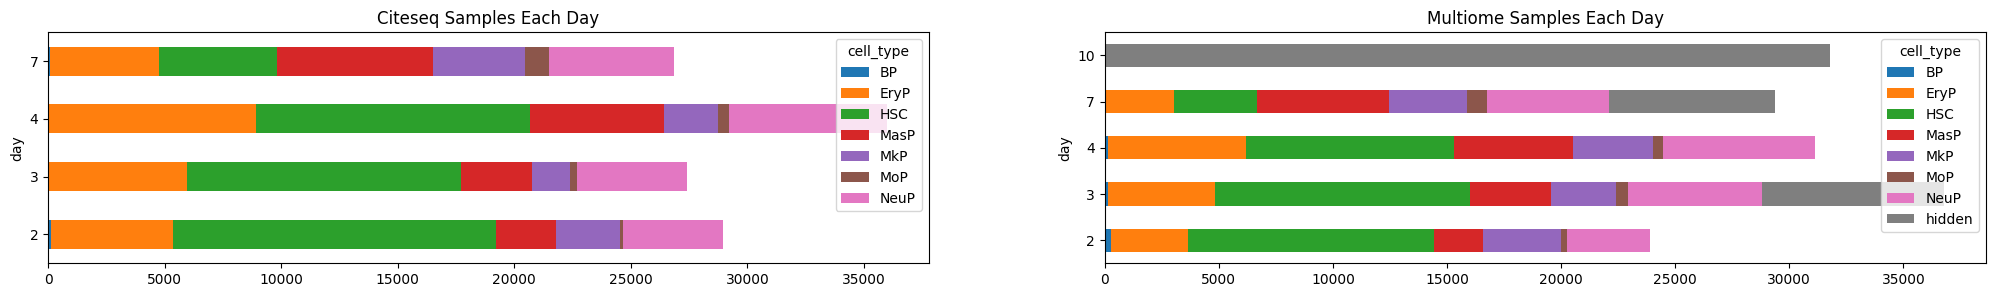

In [8]:
_, axs = plt.subplots(1, 2, figsize=(25, 3))
axs[0].set_title('Citeseq Samples Each Day')
stacked_plot(meta_cite, 'day', 'cell_type', plot = 'barh', ax = axs[0])
axs[1].set_title('Multiome Samples Each Day')
stacked_plot(meta_multi, 'day', 'cell_type', plot = 'barh', ax = axs[1])
plt.show()

**OBSERVATONS**
- In multiome, hidden cell types are from mostly from day 10 with some on day 3 and 7
- BP cells were detected only on Day 2
- MoP is also not produced much 

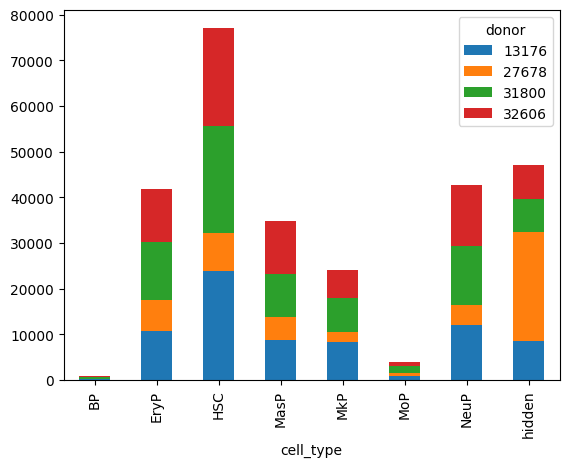

In [9]:
stacked_plot(meta_df, 'cell_type', 'donor', plot = 'bar')
plt.show()

In [10]:
# Removing the Donor 27678 (since most of donor 4's value are hidden) and all the hidden cell type to check if the Cell Type is independent of the Donor
to_check = meta_df[(meta_df.cell_type != 'hidden') & (meta_df.donor != 27678)]
crstb = pd.crosstab(index = to_check['cell_type'], columns = to_check['donor'])
crstb.drop('HSC', inplace = True)
print(crstb)
from scipy.stats import chi2_contingency as c2c
statistic, pval, dof, exfreq = c2c(crstb)
print(50 * "-", "CHI-SQUARED TEST FOR INDEPENDENCE", 50 * "-")
print(f'STATISTIC : {statistic}\n p-VALUE : {pval}\n DEGREE OF FREEDOM : {dof}\n EXPECTED FREQUENCY :\n {pd.DataFrame(exfreq, index = crstb.index, columns = crstb.columns)}')
print('WE MUST REJECT THE NULL HYPOTHESIS HENCE THERE MIGHT BE A RELATIONSHIP BETWEEN DONORS AND THE CELL TYPE')


donor      13176  31800  32606
cell_type                     
BP           222    334    222
EryP       10652  12651  11588
MasP        8793   9276  11637
MkP         8239   7584   5949
MoP          934   1548    870
NeuP       12041  12964  13313
-------------------------------------------------- CHI-SQUARED TEST FOR INDEPENDENCE --------------------------------------------------
STATISTIC : 1216.6799633588344
 p-VALUE : 3.635275486110351e-255
 DEGREE OF FREEDOM : 10
 EXPECTED FREQUENCY :
 donor             13176         31800         32606
cell_type                                          
BP           246.903887    267.897451    263.198662
EryP       11072.909406  12014.408712  11803.681882
MasP        9427.412422  10228.999604  10049.587974
MkP         6909.500547   7496.996545   7365.502907
MoP         1063.781271   1154.231693   1133.987036
NeuP       12160.492466  13194.465994  12963.041540
WE MUST REJECT THE NULL HYPOTHESIS HENCE THERE MIGHT BE A RELATIONSHIP BETWEEN DONORS AN

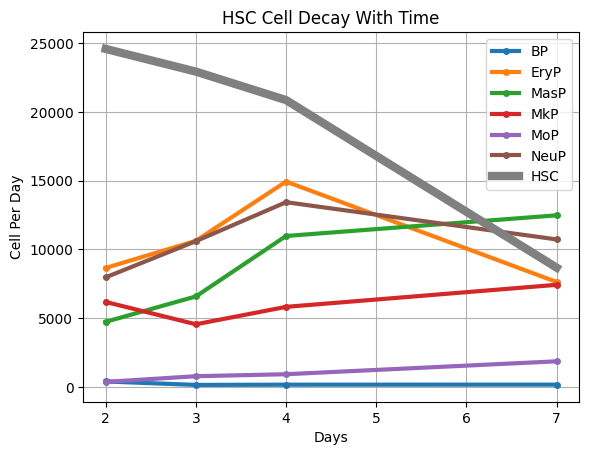

In [11]:
fig, ax = plt.subplots()
pt = pd.pivot_table(meta_df.drop(index = meta_df[meta_df.cell_type == 'hidden'].index), values='donor', index='day', columns='cell_type', aggfunc='count')
pt_trmd = pt.drop('HSC', axis = 1)
ax.plot(pt_trmd, marker = 'o', linewidth = 3, markersize = 4, label = pt_trmd.columns)
ax.plot(pt['HSC'],color = 'grey', linewidth = 6, label = 'HSC')
ax.grid()
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Cell Per Day')
ax.set_title('HSC Cell Decay With Time')
plt.show()

In [12]:
print(meta_cite.groupby('day').count()['donor'], '\n', meta_multi.groupby('day').count()['donor'])

day
2    28958
3    27389
4    35977
7    26867
Name: donor, dtype: int64 
 day
2     23911
3     36765
4     31134
7     29373
10    31773
Name: donor, dtype: int64


The variation(in the number of cells each day) is Natural considering single cell division to produce multiple cells or could possibly be some technical sampling issues

# CITEseq Samples

In [13]:
cite_df = pd.read_hdf("./Data/train_cite_inputs.h5")
cite_df

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.090185,0.000000
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.000000,0.000000,0.000000,0.000000
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.000000,3.847321,3.847321,0.000000
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.000000,3.436846,4.113780,0.000000
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.518610,4.196826,3.518610,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.397535,4.397535,5.084510,0.0,0.0,0.000000,0.000000,4.397535,4.397535
cc506e7707f5,0.0,0.0,0.0,0.0,0.0,0.000000,3.981467,4.665241,0.000000,0.000000,...,3.981467,0.000000,4.665241,3.981467,0.0,0.0,0.000000,0.000000,3.981467,0.000000
a91f1b55a520,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.497696,0.000000,4.497696,...,0.000000,0.000000,0.000000,4.497696,0.0,0.0,3.815622,4.497696,0.000000,0.000000


In [14]:
print( cite_df.isna().sum().sum(), "Missing Values")
print(int(np.round((cite_df == 0).sum().sum() / cite_df.size, 2)*100), "% Of Data Is 0")
print("All Zero Values For", (cite_df == 0).all(axis=0).sum(), "Genes")

0 Missing Values
78 % Of Data Is 0
All Zero Values For 449 Genes


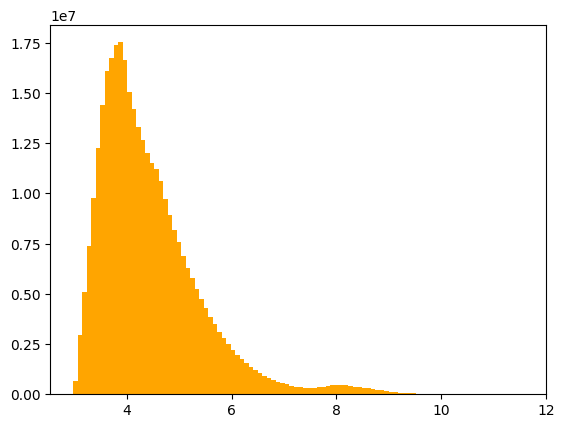

In [15]:
cite_val = cite_df.values.ravel()
cite_val = cite_val[cite_val != 0]
plt.hist(cite_val, bins = 100, color = 'orange')
plt.show()

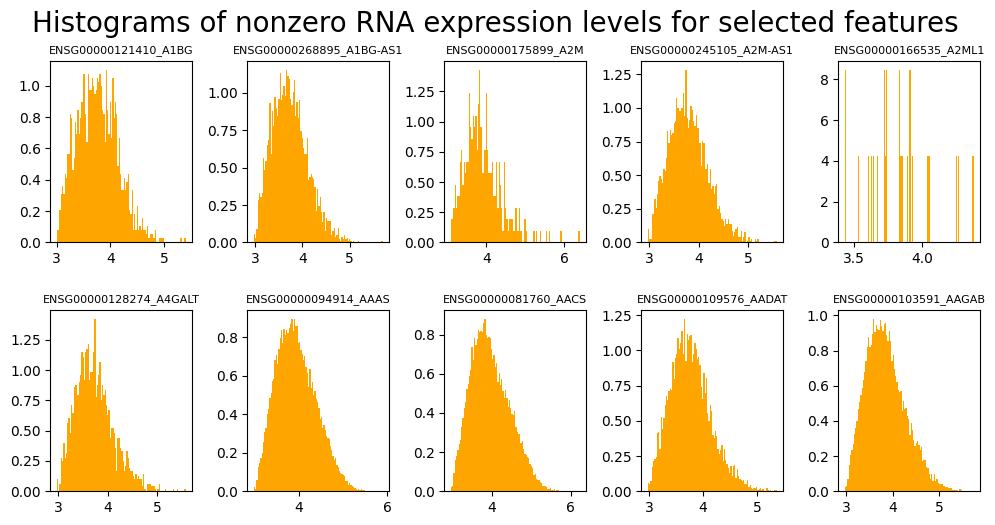

In [16]:
_, axs = plt.subplots(2, 5, figsize=(10, 5))
for col, ax in zip(cite_df.columns[: 10], axs.ravel()):
    cite_val = cite_df[col].values
    cite_val = cite_val [cite_val != 0]
    ax.hist(cite_val, bins=100, color = 'orange', density=True)
    ax.set_title(col, fontsize = 8)
plt.tight_layout(h_pad=2)
plt.suptitle('Histograms of nonzero RNA expression levels for selected features', fontsize = 20, y=1.04)
plt.show()

Shape of Cite data before SVD: (70988, 22050)
Shape of Cite data after SVD:  (70988, 3)


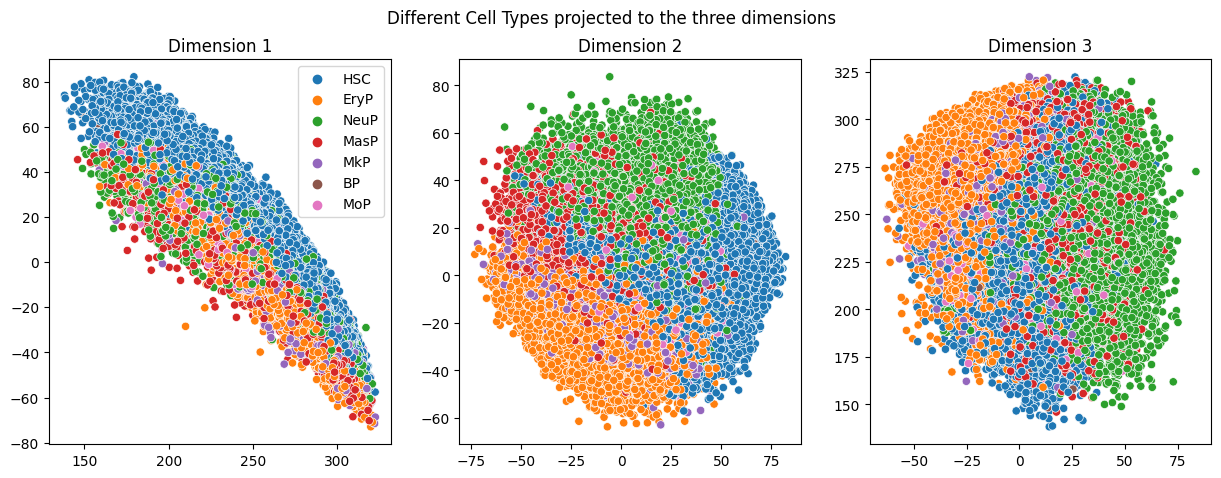

In [17]:
from sklearn.decomposition import TruncatedSVD as tSVD
print(f"Shape of Cite data before SVD: {cite_df.shape}")

#Project to 3 dimensions
svd = tSVD(n_components = 3, random_state = 1)
tr_cite_df = cite_df.reindex(meta_cite)
tr_cite_df = svd.fit_transform(cite_df)
print(f"Shape of Cite data after SVD:  {tr_cite_df.shape}")

tr_cite_df_ct = np.column_stack((tr_cite_df, meta_cite[(meta_cite.day != 7) & (meta_cite.donor != 27678)].cell_type))

_, axs = plt.subplots(1, 3, figsize = (15, 5))
sns.scatterplot(x = tr_cite_df_ct[ : , 0], y = tr_cite_df_ct[: , 1], hue = tr_cite_df_ct[: , 3], ax = axs[0])
axs[0].set_title('Dimension 1')
sns.scatterplot(x = tr_cite_df_ct[ : , 1], y = tr_cite_df_ct[: , 2], hue = tr_cite_df_ct[: , 3], ax = axs[1], legend = False)
axs[1].set_title('Dimension 2')
sns.scatterplot(x = tr_cite_df_ct[ : , 2], y = tr_cite_df_ct[: , 0], hue = tr_cite_df_ct[: , 3], ax = axs[2], legend = False)
axs[2].set_title('Dimension 3')
plt.suptitle('Different Cell Types projected to the three dimensions')
plt.show()

Shape of Cite data before SVD: (70988, 22050)
Shape of Cite data after SVD:  (70988, 2)


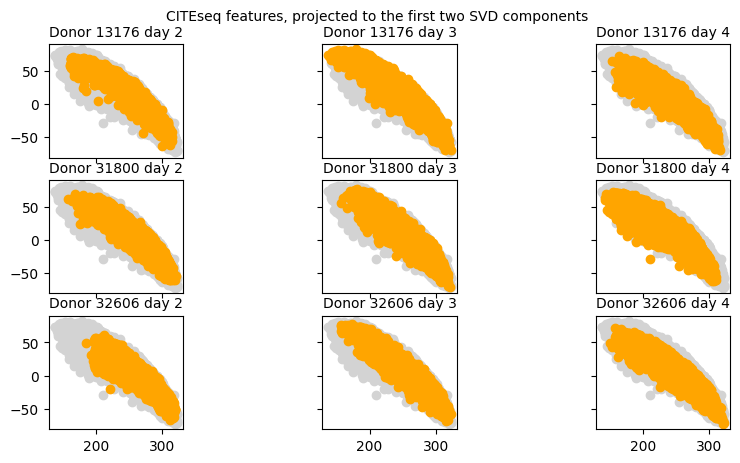

In [18]:
from sklearn.decomposition import TruncatedSVD as tSVD
print(f"Shape of Cite data before SVD: {cite_df.shape}")

# Project to 2 dimensions
svd = tSVD(n_components = 2, random_state = 1)
tr_cite_df = cite_df.reindex(meta_cite)
tr_cite_df = svd.fit_transform(cite_df)
print(f"Shape of Cite data after SVD:  {tr_cite_df.shape}")

tr_cite_df = np.column_stack((tr_cite_df, meta_cite[(meta_cite.day != 7) & (meta_cite.donor != 27678)][['day', 'donor']]))

_, axs = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (10, 5))
for donor, axrow in zip([13176, 31800, 32606], axs):
    for day, ax in zip([2, 3, 4], axrow):
        idx = np.where((tr_cite_df[:, -1] == donor) & (tr_cite_df[:, -2] == day))[0]
        not_idx = [_ for _ in range(tr_cite_df.shape[0]) if _ not in idx]        
        plt_1 = tr_cite_df[idx]
        plt_2 = tr_cite_df[not_idx]
        ax.scatter(plt_2[ : , 0], plt_2[ : ,1], color = 'lightgray')
        ax.scatter(plt_1[ : , 0], plt_1[ : ,1], color = 'orange')
        ax.set_title(f'Donor {donor} day {day}', fontsize = 10)
        ax.set_aspect('equal')
plt.suptitle('CITEseq features, projected to the first two SVD components', y = 0.95, fontsize = 10)
plt.show()

In [19]:
targets = pd.read_hdf('./Data/train_cite_targets.h5')
targets

gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.905420,0.386141,0.961590,5.090580,2.854346,6.093729,-0.586178,0.452389,0.040806,0.191407,...,1.261118,3.092832,0.003275,0.278930,-0.272002,0.249477,3.789460,0.138330,1.466193,4.278504
cc506e7707f5,2.101247,2.117462,0.112699,2.065512,2.176803,3.900090,-0.586001,-0.175479,1.363232,0.109905,...,0.714624,5.029233,0.909861,0.057322,2.633387,1.340077,11.456146,-1.431453,5.275882,2.510530
a91f1b55a520,1.221313,0.476566,1.437551,5.135631,2.926102,1.615081,-0.586910,1.760421,1.944711,-0.095096,...,-0.176027,5.027534,-0.703609,1.139491,-0.078092,1.592960,9.358179,0.981883,6.911032,3.415310


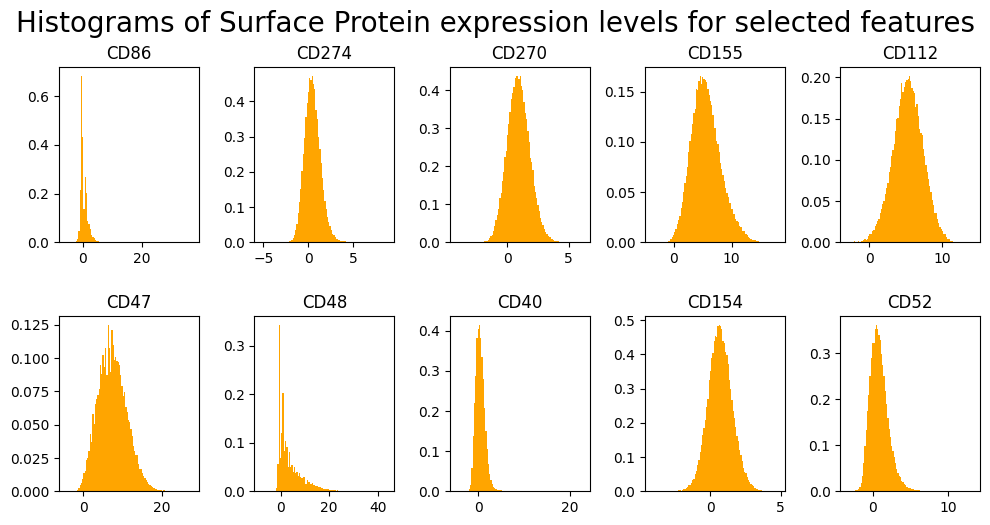

In [20]:
_, axs = plt.subplots(2, 5, figsize=(10, 5))
for col, ax in zip(targets.columns[: 10], axs.ravel()):
    target_val = targets[col].values
    target_val = target_val [target_val != 0]
    ax.hist(target_val, bins=100, color = 'orange', density=True)
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle('Histograms of Surface Protein expression levels for selected features', fontsize=20, y=1.04)
plt.show()

In [21]:
def filter_out(data, threshold=2):
    mean_value = np.mean(data)
    std_value = np.std(data)
    filtered_data = data[(data > mean_value - threshold * std_value) & (data < mean_value + threshold * std_value)]
    return filtered_data

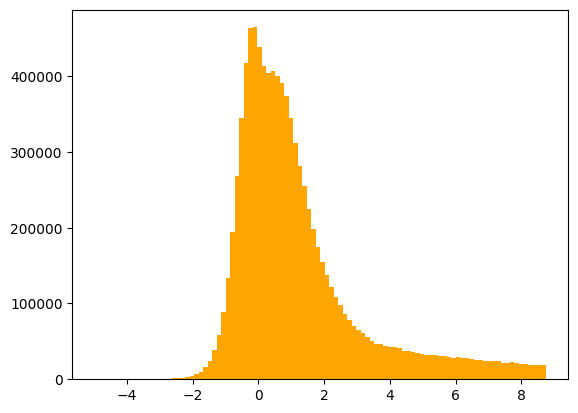

In [22]:
targets_val = targets.values.ravel()
targets_val = targets_val[targets_val != 0]
targets_val = filter_out(targets_val)
plt.hist(targets_val, bins = 100, color = 'orange')
plt.show()

In [23]:
from sklearn.decomposition import TruncatedSVD as tSVD
print(f"Shape of Target data before SVD: {targets.shape}")

# Project to 3 dimensions
svd = tSVD(n_components = 2, random_state = 1)
tr_targets = targets.reindex(meta_cite)
tr_targets = svd.fit_transform(targets)
print(f"Shape of Target data after SVD:  {tr_targets.shape}")

tr_targets = np.column_stack((tr_targets, meta_cite[(meta_cite.day != 7) & (meta_cite.donor != 27678)][['day','donor']]))

Shape of Target data before SVD: (70988, 140)
Shape of Target data after SVD:  (70988, 2)


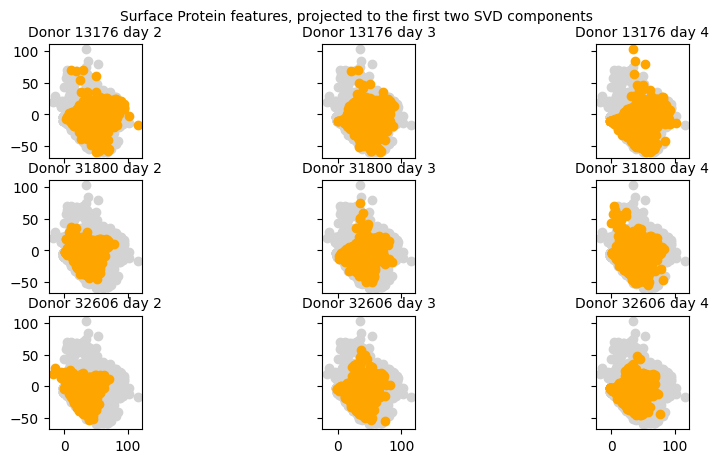

In [24]:
_, axs = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (10, 5))
for donor, axrow in zip([13176, 31800, 32606], axs):
    for day, ax in zip([2, 3, 4], axrow):
        idx = np.where((tr_targets[:, -1] == donor) & (tr_targets[:, -2] == day))[0]
        not_idx = [_ for _ in range(tr_targets.shape[0]) if _ not in idx]        
        plt_1 = tr_targets[idx]
        plt_2 = tr_targets[not_idx]
        ax.scatter(plt_2[ : , 0], plt_2[ : ,1], color = 'lightgray')
        ax.scatter(plt_1[ : , 0], plt_1[ : ,1], color = 'orange')
        ax.set_title(f'Donor {donor} day {day}', fontsize = 10)
        ax.set_aspect('equal')
plt.suptitle('Surface Protein features, projected to the first two SVD components', y = 0.95, fontsize = 10)
plt.show()

In [25]:
del cite_df, targets
gc.collect()

106710

# Multiome Samples

Loading whole multiome data into the ram would require more than 90GB of RAM, hence here i'll be reading it up in chunks to analyze it

In [26]:
bins = 100
cell_summary = pd.DataFrame()

def analyze_multiome(filename):
    global cell_summary
    start = 0
    chunksize = 5000
    total_rows = 0
    maximum_x = 0

    while True: # read the next chunk of the file
        X = pd.read_hdf(filename, start=start, stop=start+chunksize)
        if X.isna().any().any(): print('There are missing values.')
        if (X < 0).any().any(): print('There are negative values.')
        total_rows += len(X)
        print(total_rows, 'rows read')

        donors = meta_multi.donor.reindex(X.index) # metadata: donor of cell
        days = meta_multi.day.reindex(X.index) # metadata: day of cell
        chrY_cols = [f for f in X.columns if 'chrY' in f]
        maximum_x = max(maximum_x, X[chrY_cols].values.ravel().max())
        for donor in [13176, 31800, 32606, 27678]:
            hist, _ = np.histogram(X[chrY_cols][donors == donor].values.ravel(), bins=bins, range=(0, 15))
            chrY_histo[donor] += hist

        cell_summary = pd.concat([cell_summary,
                                  pd.DataFrame({'donor': donors,
                                                'day': days,
                                                'total': X.sum(axis=1),
                                                'total_nonzero': (X != 0).sum(axis=1)})])
        if len(X) < chunksize: break
        start += chunksize

    display(X.head(3))
    print(f"Zero entries in {filename}: {(X == 0).sum().sum() / X.size:.0%}")

chrY_histo = dict()
for donor in [13176, 31800, 32606, 27678]:
    chrY_histo[donor] = np.zeros((bins, ), int)

# Look at the training data
analyze_multiome('./Data/train_multi_inputs.h5')


5000 rows read
10000 rows read
15000 rows read
20000 rows read
25000 rows read
30000 rows read
35000 rows read
40000 rows read
45000 rows read
50000 rows read
55000 rows read
60000 rows read
65000 rows read
70000 rows read
75000 rows read
80000 rows read
85000 rows read
90000 rows read
95000 rows read
100000 rows read
105000 rows read
105942 rows read


gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
13cb628b8773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0803092e6b4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.082841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e8e7ff56f262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Zero entries in /kaggle/input/open-problems-multimodal/train_multi_inputs.h5: 98%


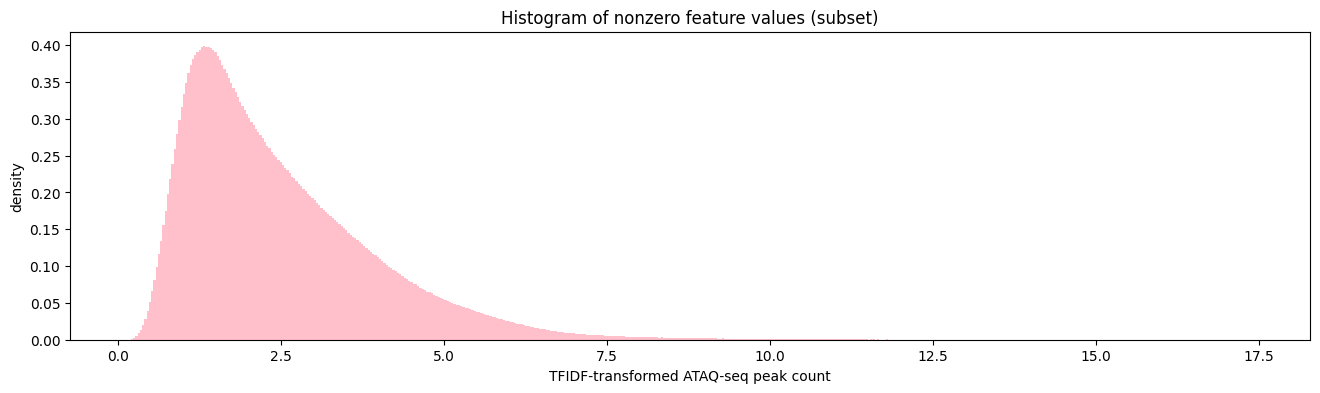

In [27]:
multi_df = pd.read_hdf("./Data/train_multi_inputs.h5", start = 0, stop = 5000)
multi_val = multi_df.values.ravel()
multi_val = multi_val[multi_val != 0] 
plt.figure(figsize=(16, 4))
plt.hist(multi_val, bins=500, density=True, color='pink')
del multi_val
plt.title("Histogram of nonzero feature values (subset)")
plt.xlabel("TFIDF-transformed ATAQ-seq peak count")
plt.ylabel("density")
plt.show()

del multi_df

In [28]:
analyze_multiome('./Data/test_multi_inputs.h5')

5000 rows read
10000 rows read
15000 rows read
20000 rows read
25000 rows read
30000 rows read
35000 rows read
40000 rows read
45000 rows read
50000 rows read
55000 rows read
55935 rows read


gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
079ddaa2be77,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43ee19ddefb3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f82d95f0637f,0.0,0.0,0.0,2.372443,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Zero entries in /kaggle/input/open-problems-multimodal/test_multi_inputs.h5: 97%


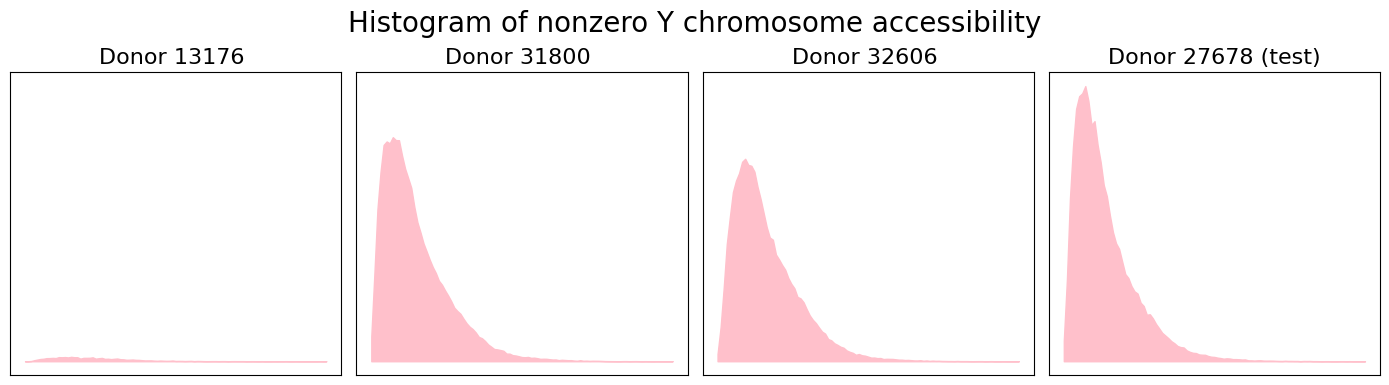

In [29]:
plt.rcParams['savefig.facecolor'] = "1.0"
_, axs = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (14, 4))
for donor, ax in zip([13176, 31800, 32606, 27678], axs):
    ax.set_title(f"Donor {donor} {'(test)' if donor == 27678 else ''}", fontsize = 16)
    total = chrY_histo[donor].sum() 
    ax.fill_between(range(bins-1), chrY_histo[donor][1:] / total, color='pink')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Histogram of nonzero Y chromosome accessibility", y=0.95, fontsize=20)
plt.tight_layout()
plt.show()

Since the Y Chromosomes are not present (Y Chromosomes levels are low) in donor 13176, we can say that the donor is a Feamale and rest are Males, introducing a gender angle to our data

In [30]:
cell_summary = pd.DataFrame()
start = 0
chunksize = 10000
total_rows = 0
while True:
    targets = pd.read_hdf("./Data/train_multi_targets.h5", start=start, stop=start+chunksize)
    if targets.isna().any().any(): print('There are missing values.')
    if (targets < 0).any().any(): print('There are negative values.')
    total_rows += len(targets)
    print(total_rows, 'rows read')

    donors = meta_multi.donor.reindex(targets.index) # metadata: donor of cell
    days = meta_multi.day.reindex(targets.index) # metadata: day of cell
    cell_summary = pd.concat([cell_summary,
                              pd.DataFrame({'donor': donors,
                                            'day': days,
                                            'total': targets.sum(axis=1),
                                            'total_nonzero': (targets != 0).sum(axis=1)})])
    
    if len(targets) < chunksize: break
    start += chunksize
    
display(targets.head())

10000 rows read
20000 rows read
30000 rows read
40000 rows read
50000 rows read
60000 rows read
70000 rows read
80000 rows read
90000 rows read
100000 rows read
105942 rows read


gene_id,ENSG00000121410,ENSG00000268895,ENSG00000175899,ENSG00000245105,ENSG00000166535,ENSG00000256661,ENSG00000184389,ENSG00000128274,ENSG00000094914,ENSG00000081760,...,ENSG00000086827,ENSG00000174442,ENSG00000122952,ENSG00000198205,ENSG00000198455,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755
cell_id,,,,,,,,,,,,,,,,,,,,,
1777f8908031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,6.271747,0.0,0.000000,0.000000,0.000000
7b88c4c3021b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,4.251612,0.000000,0.0,0.0,5.627168,0.0,0.000000,4.251612,5.340685
34f17c8aece8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,5.349229,0.0,0.0,0.000000,0.0,4.660822,5.753109,0.000000
f02fabdccd4b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.606937,4.606937,...,0.000000,4.606937,0.000000,0.0,0.0,4.606937,0.0,0.000000,0.000000,0.000000
6083c6994d3e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,4.245897,0.000000,4.245897,0.0,0.0,0.000000,0.0,0.000000,0.000000,4.931858


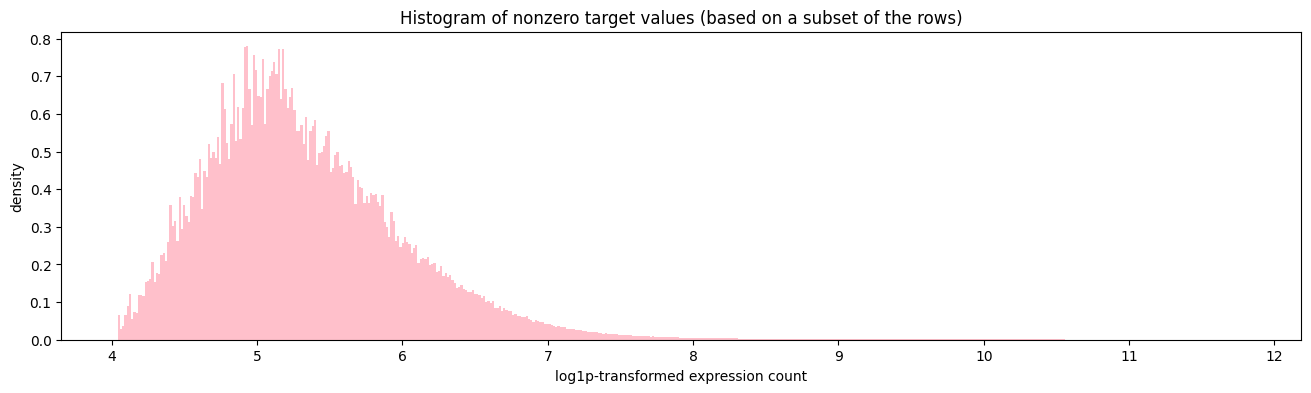

In [31]:
targets_val = targets.values.ravel()
targets_val = targets_val[targets_val != 0]
plt.figure(figsize=(16, 4))
plt.hist(targets_val, bins = 500, density = True, color = 'pink')
del targets_val
plt.title("Histogram of nonzero target values (based on a subset of the rows)")
plt.xlabel("log1p-transformed expression count")
plt.ylabel("density")
plt.show()

-----------------------